# **CS 725 Project : Extraction of 2D footprints of buildings using LIDAR points**

TEAM MEMBERS:


1. Sona Elza Simon (22D1591) 
2. Apurva Dhingra (22D1592)
3. Sarvesh Gharat (22D1593)
4. Deekshant Kumar (22D1595)
5. Sandhya Dasari  (213040056)

# **Libraries**

In [ ]:
!pip install geemap
!git clone https://github.com/geopandas/geopandas.git
!pip install geopandas
!pip install laspy[lazrs,laszip] 
!pip install folium 
!pip install matplotlib 
!pip install mapclassify
!pip install alphashape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.8 MB/s 
     |████████████████████████████████| 46 kB 4.9 MB/s 
     |████████████████████████████████| 55 kB 5.5 MB/s 
     |████████████████████████████████| 3.0 MB 55.0 MB/s 
     |████████████████████████████████| 8.8 MB 56.3 MB/s 
     |████████████████████████████████| 3.7 MB 48.4 MB/s 
     |████████████████████████████████| 99 kB 11.7 MB/s 
     |████████████████████████████████| 1.3 MB 57.6 MB/s 
     |████████████████████████████████| 130 kB 72.6 MB/s 
     |████████████████████████████████| 98 kB 10.0 MB/s 
     |████████████████████████████████| 1.2 MB 66.0 MB/s 
     |████████████████████████████████| 198 kB 77.8 MB/s 
     |████████████████████████████████| 128 kB 74.4 MB/s 
     |████████████████████████████████| 1.6 MB 62.4 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 

Cloning into 'geopandas'...
remote: Enumerating objects: 12755, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 12755 (delta 4), reused 5 (delta 2), pack-reused 12739
Receiving objects: 100% (12755/12755), 56.06 MiB | 33.76 MiB/s, done.
Resolving deltas: 100% (8623/8623), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.5 MB/s 
     |████████████████████████████████| 6.3 MB 59.4 MB/s 
     |████████████████████████████████| 16.7 MB 55.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 615 kB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 306 kB 57.8 MB/s 
     |████████████████████████████████| 1

In [ ]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
# Libraries required for the implementation of ANN

import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# Libraries required for extracting the 2D footprint of the buildings

import geopandas as gpd
import folium
import geemap

from sklearn.cluster import DBSCAN

import alphashape
from descartes import PolygonPatch

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# **Read the LiDAR data**

In [ ]:
# Mounting to google drive

# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/IIT Bombay/CS 725 Project/')

Mounted at /content/drive


In [ ]:
# Reading lidar data from las file

# filename = 'C_37EZ1_7415_sample.las'
filename = 'Dataset/C_37EZ1_7415_sample.las'
las = geemap.read_lidar(filename)
print("Las file details: ",las)

Las file details:  <LasData(1.2, point fmt: <PointFormat(1, 0 bytes of extra dims)>, 1826741 points, 3 vlrs)>


In [ ]:
# Number of lidar points

print("Number of point clouds: ",las.header.point_count)

Number of point clouds:  1826741


In [ ]:
# Lidar data features

print("Features in the las file: \n",list(las.point_format.dimension_names))

Features in the las file: 
 ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time']


# **Data Pre-processing**

In [ ]:
# Creating dataframe using selected features

df = pd.DataFrame(np.hstack((las.X[:,None], las.Y[:,None], las.Z[:, None], las.return_number[:,None], las.classification[:,None], las.intensity[:,None])),
                  columns = ['long', 'lat', 'elev', 'rt_num', 'class', 'intensity'])
df.head()

,long,lat,elev,rt_num,class,intensity
0,83150336,439662362,313,1,1,141
1,83150412,439662657,-39,1,1,126
2,83150429,439662496,-883,2,1,13
3,83150513,439662685,-1709,1,2,248
4,83150298,439660188,-1690,1,2,447


In [ ]:
# Scaling longtitude and latitude

df['long'] = (df['long']/1000)
df['lat'] = (df['lat']/1000)
df.head()

,long,lat,elev,rt_num,class,intensity
0,83150.336,439662.362,313,1,1,141
1,83150.412,439662.657,-39,1,1,126
2,83150.429,439662.496,-883,2,1,13
3,83150.513,439662.685,-1709,1,2,248
4,83150.298,439660.188,-1690,1,2,447


In [ ]:
# Converting to GeoDataFrame geometry

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['long'], df['lat'], crs ="EPSG:28992"))
gdf = gdf.to_crs("EPSG:4326")
gdf.head()

,long,lat,elev,rt_num,class,intensity,geometry
0,83150.336,439662.362,313,1,1,141,POINT (4.34228 51.94077)
1,83150.412,439662.657,-39,1,1,126,POINT (4.34229 51.94077)
2,83150.429,439662.496,-883,2,1,13,POINT (4.34229 51.94077)
3,83150.513,439662.685,-1709,1,2,248,POINT (4.34229 51.94077)
4,83150.298,439660.188,-1690,1,2,447,POINT (4.34228 51.94075)


In [ ]:
# For experimentation, we are using a subset of the Lidar Data

h=gdf[0:180000] 

# **2D Building Footprint Using Lidar Points**

## Lidar points of the class : Buildings

In [ ]:
h1=h.loc[h['class'] == 6] # buildings only
h1.head()

,long,lat,elev,rt_num,class,intensity,geometry
27,83150.319,439657.499,1166,1,6,59,POINT (4.34229 51.94073)
49,83150.389,439656.063,1171,1,6,157,POINT (4.34229 51.94071)
50,83150.454,439656.398,1172,1,6,102,POINT (4.34229 51.94072)
51,83150.521,439656.742,1156,1,6,56,POINT (4.34229 51.94072)
52,83150.584,439657.090,1221,1,6,125,POINT (4.34229 51.94072)


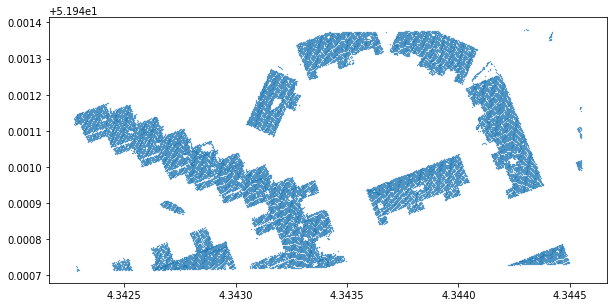

In [ ]:
# Visualizing the building data

h1.plot(figsize = (10,10), markersize=0.1)

## Kmeans

In [ ]:
# Kmeans Clustering

from sklearn.cluster import KMeans

X = h1[['long','lat']]

kmeans = KMeans(n_clusters=18, random_state=0).fit(X)

n_cluster = len(set(kmeans.labels_))
print("Number of clusters obtained from DBSCAN: ",n_cluster)

Number of clusters obtained from DBSCAN:  18


In [ ]:
# Updating the dataframe with the cluster labels

h1_ = h1.copy()
h1_ = h1_.assign(cluster_label = kmeans.labels_)
h1_.head(5)

,long,lat,elev,rt_num,class,intensity,geometry,cluster_label
27,83150.319,439657.499,1166,1,6,59,POINT (4.34229 51.94073),14
49,83150.389,439656.063,1171,1,6,157,POINT (4.34229 51.94071),14
50,83150.454,439656.398,1172,1,6,102,POINT (4.34229 51.94072),14
51,83150.521,439656.742,1156,1,6,56,POINT (4.34229 51.94072),14
52,83150.584,439657.090,1221,1,6,125,POINT (4.34229 51.94072),14


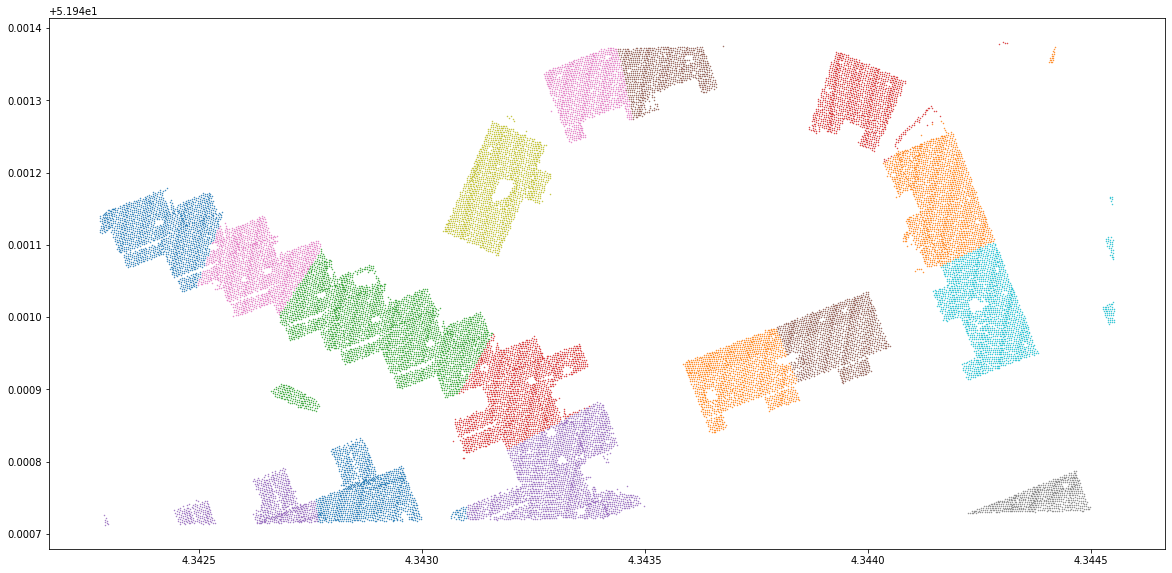

In [ ]:
# Plotting the clusters

ax = h1_.plot(figsize = (20,30),c='w',markersize=0.2)
for i in range(0,n_cluster-1):
  h1_.loc[h1_['cluster_label'] == i].plot(figsize = (20,30), markersize=0.2, ax=ax)

## DBSCAN

In [ ]:
# DBSCAN Clustering

X = h1[['long','lat']]

clusters = DBSCAN(eps=0.5, min_samples=4).fit(X)

n_cluster = len(set(clusters.labels_))
print("Number of clusters obtained from DBSCAN: ",n_cluster)

Number of clusters obtained from DBSCAN:  18


In [ ]:
# Updating the dataframe with the cluster labels

h1 = h1.assign(cluster_label = clusters.labels_)
h1.head(5)

,long,lat,elev,rt_num,class,intensity,geometry,cluster_label
27,83150.319,439657.499,1166,1,6,59,POINT (4.34229 51.94073),0
49,83150.389,439656.063,1171,1,6,157,POINT (4.34229 51.94071),0
50,83150.454,439656.398,1172,1,6,102,POINT (4.34229 51.94072),0
51,83150.521,439656.742,1156,1,6,56,POINT (4.34229 51.94072),0
52,83150.584,439657.090,1221,1,6,125,POINT (4.34229 51.94072),0


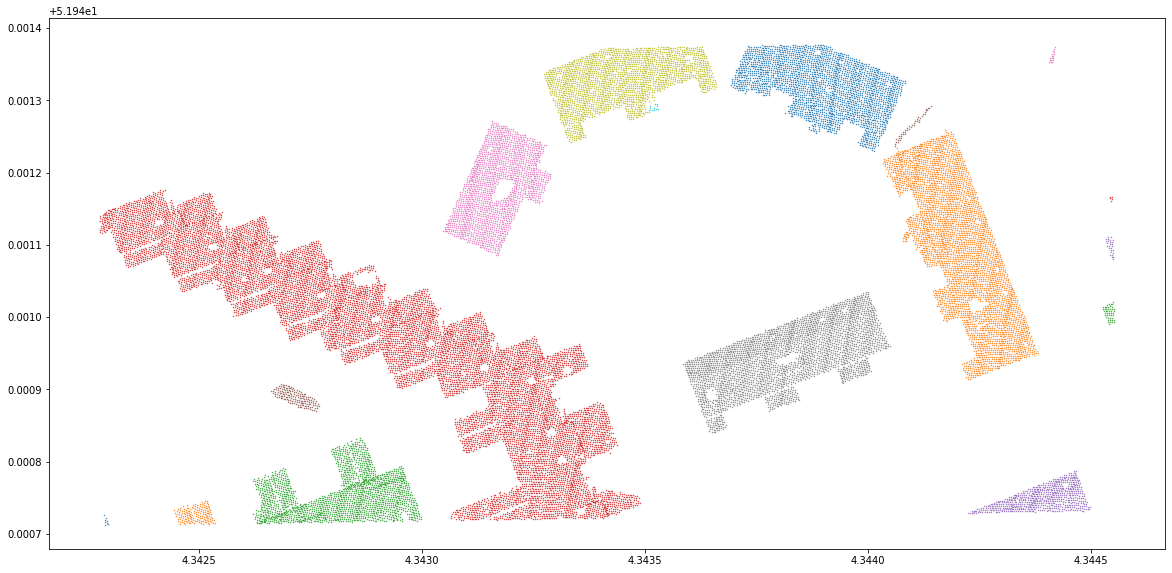

In [ ]:
# Plotting the clusters

ax = h1.plot(figsize = (20,30),c='w',markersize=0.2)
for i in range(0,n_cluster-1):
  h1.loc[h1['cluster_label'] == i].plot(figsize = (20,30), markersize=0.2, ax=ax)

## Convex Hull

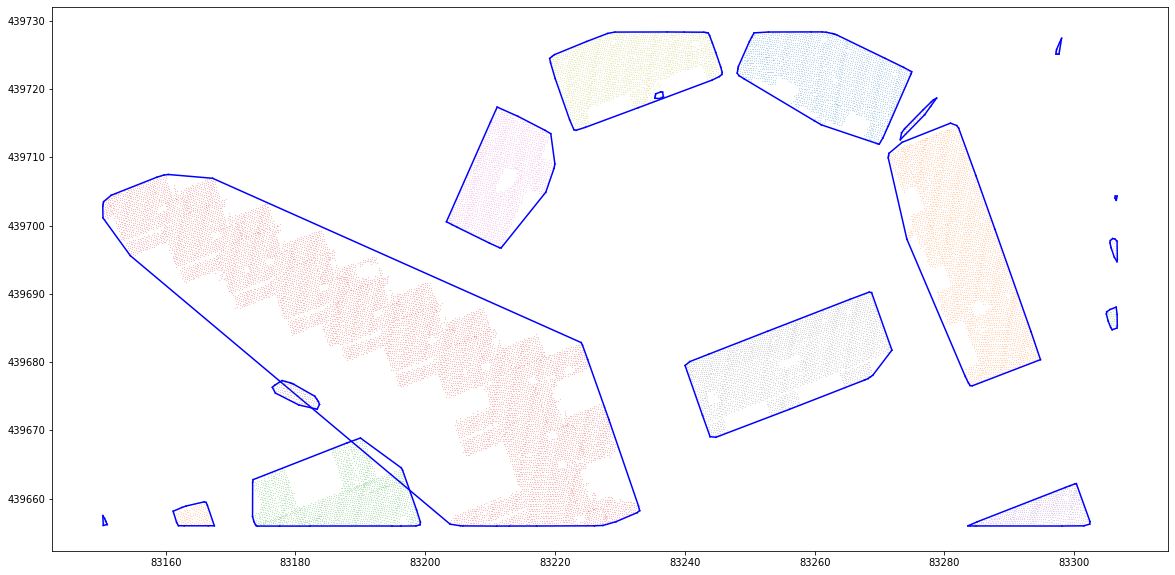

In [ ]:
# Drawing building footprint boundary using Convex Hull

from scipy.spatial import ConvexHull

figure(figsize=(20, 10))
z=[]
for i in range (0,n_cluster-1):
    h2=h1.loc[h1['cluster_label'] == i]
    Y = np.array(h2[['long', 'lat']])
    hull = ConvexHull(Y)
    ploted = plt.plot(Y[:, 0],Y[:, 1],'o', markersize=0.1)
    z.append(Y[hull.vertices,:].tolist())
    for simplex in hull.simplices:
        ploted=plt.plot(Y[simplex, 0], Y[simplex, 1],c='b', markersize=0.1)

## Alphashape 

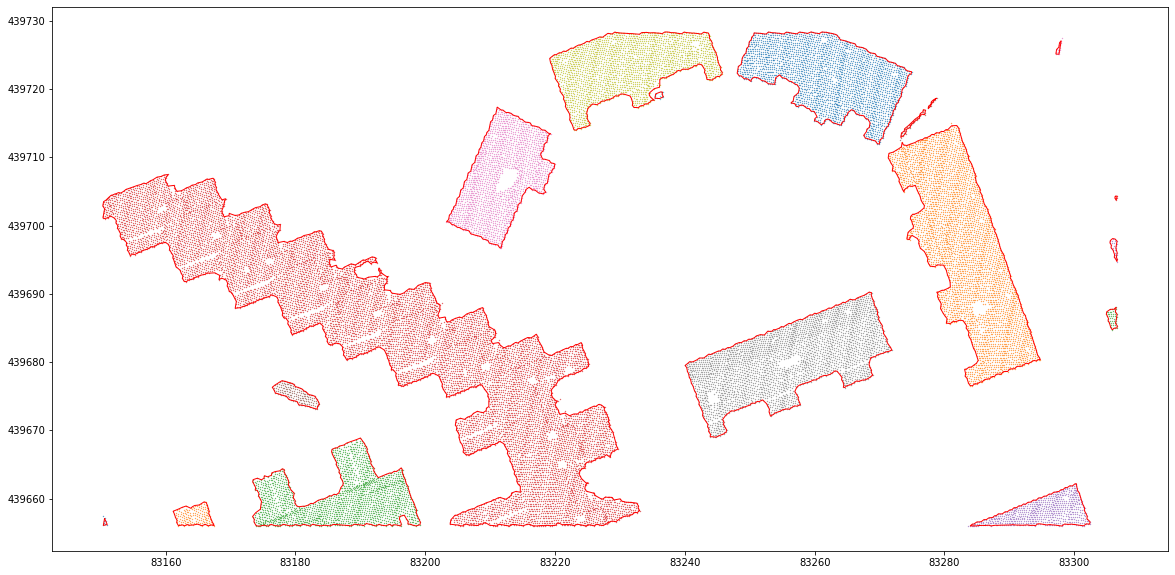

In [ ]:
# Drawing building footprint boundary using AlphaShape

fig, ax = plt.subplots(figsize=(20,10))
for i in range (0,n_cluster-1):
    h2=h1.loc[h1['cluster_label'] == i]
    Y = np.array(h2[['long', 'lat']])
    alpha_shape = alphashape.alphashape(Y,2)
    ax.scatter(*zip(*Y),s=0.1)
    ax.add_patch(PolygonPatch(alpha_shape,fill=False,linewidth=1, ec='r'))
plt.show()